In [20]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (summarize,
                         poly,
                         ModelSpec as MS)
from statsmodels.stats.anova import anova_lm
from pygam import (s as s_gam,
                   l as l_gam,
                   f as f_gam,
                   LinearGAM,
                   LogisticGAM)

from ISLP.transforms import (BSpline,
                             NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam,
                        degrees_of_freedom,
                        plot as plot_gam,
                        anova as anova_gam)
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from ISLP.models import sklearn_sm
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import statsmodels.api as sm
import ISLP
from ISLP import load_data
from ISLP.models import (ModelSpec as MS,
                         summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import SplineTransformer
import seaborn as sns
import itertools
from sklearn.pipeline import Pipeline
sns.set_palette("pastel")

In [205]:
wage = load_data("Wage")
wage = wage[["wage", "age"]]

In [206]:
categories = list(wage.drop('wage', axis=1).select_dtypes(include=['category']).columns)
numericals = list(wage.drop('wage', axis=1).select_dtypes(include='number').columns)

In [207]:
fig, axes = plt.subplots(nrows=len(categories)//2, ncols=2, figsize=(15, 10))
axes = axes.flatten()
for ax, cat in zip(axes, categories):
    sns.violinplot(data=wage, x=cat, y='wage', ax=ax, hue=cat)
    ax.set_title(f"wage by {cat}")
    ax.set_xlabel(cat)
    ax.set_ylabel('wage')
plt.tight_layout()
plt.show()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1500x1000 with 0 Axes>

In [208]:
def polynomial_transform(X, degree=2):
    """
    Transform input array X into its polynomial features up to a given degree.
    
    Parameters:
    - X: array-like of shape (n_samples, 1)
    - degree: int, maximum polynomial degree
    
    Returns:
    - X_poly: array of shape (n_samples, degree)
    """
    X = np.asarray(X)
    # Ensure X is 2D
    if X.ndim == 1:
        X = X[:, np.newaxis]
    
    # Generate polynomial features
    X_poly = np.hstack([X ** i for i in range(1, degree + 1)])
    return X_poly

In [223]:
preprocess_poly = ColumnTransformer(
    transformers=[
        ('poly_scaled', Pipeline([
            ('poly', FunctionTransformer(lambda x: polynomial_transform(x, degree=3))),
            ('scaler', StandardScaler())]), numericals),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categories)
    ])

model_1 = Pipeline([
    ('preprocess', preprocess_poly),
    ('regressor', ElasticNetCV(l1_ratio = 1))
])


preprocess_spline = ColumnTransformer(
    transformers=[
        ('spline_scaled', Pipeline([
            ('spline', SplineTransformer(n_knots=3, knots='uniform', extrapolation='linear')),
            ('num', StandardScaler())]), numericals),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categories)
    ])

model_2 = Pipeline([
    ('preprocess', preprocess_spline),
    ('regressor', ElasticNetCV(l1_ratio = 1))
])

In [224]:
%%capture
res = np.mean(cross_validate(model_1, wage.drop("wage", axis=1,), wage["wage"], scoring='neg_mean_squared_error')['test_score']),np.mean(cross_validate(model_2, wage.drop("wage", axis=1,), wage["wage"], scoring='neg_mean_squared_error')['test_score'])

In [228]:
%%capture
model_1.fit(wage.drop("wage", axis=1,), wage['wage'])
model_2.fit(wage.drop("wage", axis=1,), wage['wage'])

<Axes: xlabel='age', ylabel='wage'>

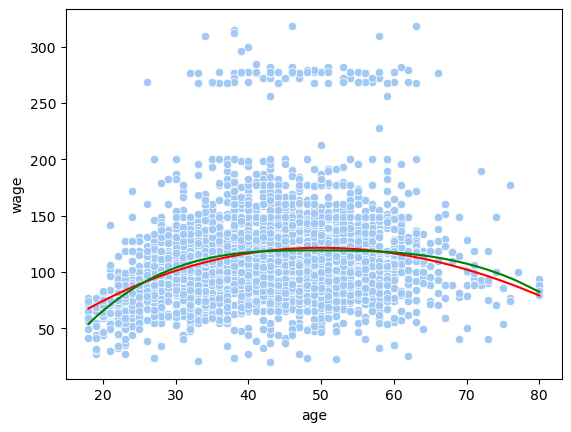

In [234]:
sns.lineplot(x=wage['age'], y=model_1.predict(wage.drop("wage", axis=1,)), color = 'red')
sns.lineplot(x=wage['age'], y=model_2.predict(wage.drop("wage", axis=1,)), color = 'green')
sns.scatterplot(x=wage['age'], y=wage['wage'])


In [219]:
%%capture
poly_degree = []
train_mse = []
for i in range(1,20):
    preprocess_poly = ColumnTransformer(
        transformers=[
            ('poly_scaled', Pipeline([
                ('poly', FunctionTransformer(lambda x: polynomial_transform(x, degree=i))),
                ('scaler', StandardScaler())]), numericals),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categories)
        ])
    model_1 = Pipeline([
        ('preprocess', preprocess_poly),
        ('regressor', ElasticNetCV(l1_ratio = 1))
    ])
    model_1.fit(wage.drop("wage", axis=1,), wage["wage"])
    predict = model_1.predict(wage.drop("wage", axis=1,))
    poly_degree.append(-np.mean(cross_validate(model_1, wage.drop("wage", axis=1,), wage["wage"], scoring='neg_mean_squared_error')['test_score']))

<Axes: >

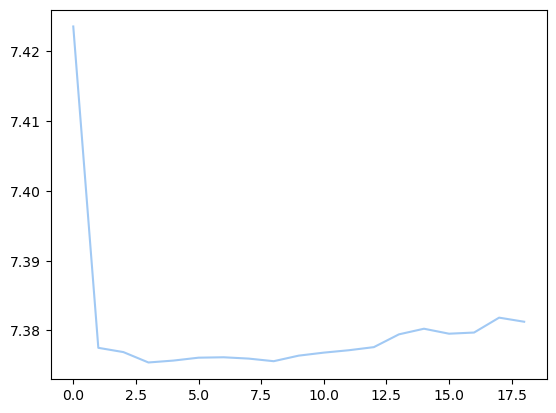

In [220]:
sns.lineplot(np.log(poly_degree))

In [214]:
%%capture
cross_knots = []
for i in range(2,20):
    preprocess_spline = ColumnTransformer(
        transformers=[
            ('spline_scaled', Pipeline([
                ('spline', SplineTransformer(n_knots=i, knots='uniform', extrapolation='linear')),
                ('num', StandardScaler())]), numericals),
            ('cat', OneHotEncoder(handle_unknown='ignore'), categories)
        ])
    
    model_2 = Pipeline([
        ('preprocess', preprocess_spline),
        ('regressor', ElasticNetCV(l1_ratio = 1))
]) 
    cross_knots.append(-np.mean(cross_validate(model_2, wage.drop("wage", axis=1,), wage["wage"], scoring='neg_mean_squared_error')['test_score']))

<Axes: >

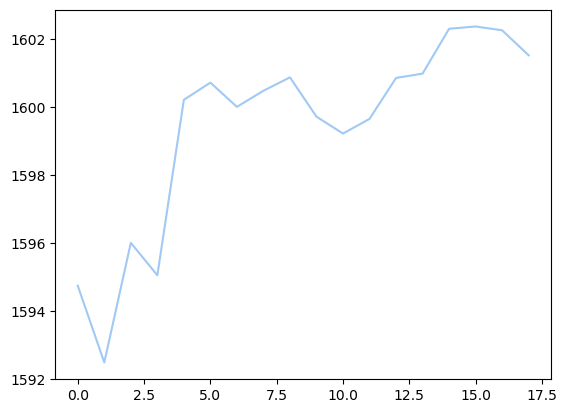

In [221]:
sns.lineplot(cross_knots)